# Imports


In [1]:
import numpy as p
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime
import json
sns.set_style("whitegrid")

In [2]:
logins = pd.read_json('datasets/logins.json', convert_dates = True)
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

## EDA

In [3]:
#Checking the type of the column
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [4]:
logins['login_counts'] = 1

In [5]:
logins.head()

login_time  login_counts
0 1970-01-01 20:13:18             1
1 1970-01-01 20:16:10             1
2 1970-01-01 20:16:37             1
3 1970-01-01 20:16:36             1
4 1970-01-01 20:26:21             1

In [6]:
logins=logins.set_index('login_time')

In [7]:
_grouped_data = logins.resample('15min')['login_counts'].count()

In [8]:
_grouped_data.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, Name: login_counts, dtype: int64

In [9]:
logins_15_min_counts = pd.DataFrame(_grouped_data)

In [10]:
logins_15_min_counts.head()

login_counts
login_time                       
1970-01-01 20:00:00             2
1970-01-01 20:15:00             6
1970-01-01 20:30:00             9
1970-01-01 20:45:00             7
1970-01-01 21:00:00             1

In [11]:
logins_15_min_counts.describe()

login_counts
count   9788.000000
mean       9.515938
std        8.328818
min        0.000000
25%        3.000000
50%        7.000000
75%       13.000000
max       73.000000

In [12]:
logins_15_min_counts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
login_counts    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


In [13]:
# Plotting demand 
logins_15_min_counts.plot()
plt.show()

This graph is too dense, we need to perform smoothing by daily demand.

In [14]:
logins_15_min_counts.rolling(window=96).mean().plot()

It looks like demand has a weekly cycle.

In [15]:
# zooming into a one month cycle
logins_15_min_counts.loc['1970-02'].plot()

In [16]:
#Creating a daily count graph
logins_15_min_counts.loc['1970-02'].rolling(window=96).mean().plot()


It looks like demand rises on weekends. But let's zoom into one week to see it clearly.

In [17]:
datetime.datetime(1970, 1, 1).weekday()

3

The first day of the week is a thursday

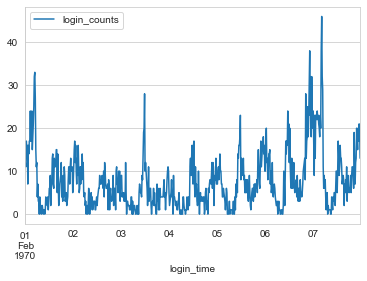

In [18]:
logins_15_min_counts.loc['1970-02-01':'1970-02-07'].plot()
plt.show()

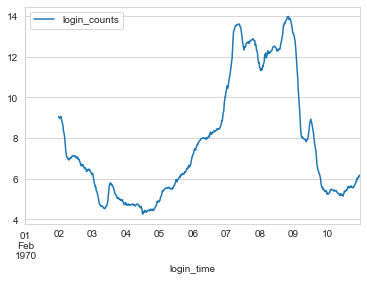

In [19]:
logins_15_min_counts.loc['1970-02-01':'1970-02-10'].rolling(window=96).mean().plot()
plt.show()

In [20]:
logins_15_min_counts.loc['1970-02-06':'1970-02-08'].plot()

It looks like the highest demand is around midnight on the weekends

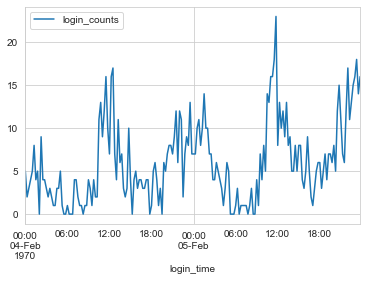

In [21]:
logins_15_min_counts.loc['1970-02-04':'1970-02-05'].plot()
plt.show()

Looks like on weekdays, demand is highest both at midnight and at noon.

## Experiments and Metric Design 
* What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 

A reasonable metric to choose would be the number of crossings. Since the company decided to take care of the toll cost, there should be an increase of crossings on weekdays during the day to Metropolis and on the same weekdays but at night the percentage of drivers crossing to Gotham should be increasing to take care of the increasing demand there. So a key metric would definitely be the percentage of crossings to Metropolis or Gotham based on the complementary circadian rythm on weekdays of the two cities. 

Another metric could also be the amount of money Ultimate pays on tolls, the more the total amount of toll expenditure increases on weekdays, the more 'successful' the strategy.

* Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

    - How you will implement the experiment
        We would evaluate the change in the percentage of drivers that cross comparing the before company policy change numbers and the after policy change percentage.
        
    - What statistical test(s) you will conduct to verify the significance of the
        observation.        
        Using a hypothesis test comparing population proportions. On a given time frame and on weekdays for example during daytime. What is the proportion of drivers that cross from Gotham to Metropolis ? The null hypothesis being that there is no change in that proportion.

    - How you would interpret the results and provide recommendations to the city
        operations team along with any caveats.        
        If there is a change in the proportion of drivers crosssing, then the policy change would have proven effective. If there is a little to no percentage change then it would have proven inneffective. If the policy change proves inneffective, then there are probably other factors worth considering as to why this was the case. Maybe there is a competitor in one of the city or both that has lower prices so the demand for Utimate drivers does not increase as it should be where it should be. The drivers may also be more reluctant to cross for other outside factors such as too much crime in Gotham at night for instance, this is pure speculation but factors like these are worth considering if the policy change doesn't incentivize the drivers to cross. 

## Predictive Modelling

In [22]:
with open('datasets/ultimate_data_challenge.json') as f:
    data = json.load(f)
ultimate_data_challenge = pd.DataFrame(data)

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

In [23]:
display(ultimate_data_challenge.shape)
display(ultimate_data_challenge.info())
display(ultimate_data_challenge.columns)

(50000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


None

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [24]:
ultimate_data_challenge.head()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  \
0      3.67                   5.0                   4.7       1.10   
1      8.26                   5.0                   5.0       1.00   
2      0.77                   5.0                   4.3       1.00   
3      2.36                   4.9                   4.6       1.14   
4      3.13                   4.9                   4.4       1.19   

             city last_trip_date    phone signup_date  surge_pct  \
0  King's Landing     2014-06-17   iPhone  2014-01-25       15.4   
1         Astapor     2014-05-05  Android  2014-01-29        0.0   
2         Astapor     2014-01-07   iPhone  2014-01-06        0.0   
3  King's Landing     2014-06-29   iPhone  2014-01-10       20.0   
4      Winterfell     2014-03-15  Android  2014-01-27       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  
0                       4                 True         46.2  
1                       0                False         50.0  
2                       3                False        100.0  
3                       9                 True         80.0  
4                      14                False         82.4

In [25]:
ultimate_data_challenge.describe()


avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct  
count  50000.000000            50000.000000  50000.000000  
mean       8.849536                2.278200     60.926084  
std       19.958811                3.792684     37.081503  
min        0.000000                0.000000      0.000000  
25%        0.000000                0.000000     33.300000  
50%        0.000000                1.000000     66.700000  
75%        8.600000                3.000000    100.000000  
max      100.000000              125.000000    100.000000

In [26]:
ultimate_data_challenge.last_trip_date = pd.to_datetime(ultimate_data_challenge.last_trip_date)
ultimate_data_challenge.signup_date = pd.to_datetime(ultimate_data_challenge.signup_date)

In [27]:
ultimate_data_challenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [28]:
ultimate_data_challenge['last_trip_date'].describe()


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [29]:
fraction_retained = (ultimate_data_challenge.last_trip_date >= '2014-06-01').sum() / (ultimate_data_challenge.last_trip_date >= '2014-06-01').count()
fraction_retained

0.37608

We create a user retention column that we make our target

In [30]:
ultimate_data_challenge['was_retained'] = (ultimate_data_challenge.last_trip_date >= '2014-06-01')*1


In [31]:
# Let's plot our data 

fig = plt.figure()
ax = plt.subplot(111)
corr = ultimate_data_challenge.corr()
ax = sns.heatmap(corr)
plt.show()

In [32]:
corr['was_retained'].sort_values(ascending=False)


was_retained              1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: was_retained, dtype: float64

Retention here si related with trips in the frist 30 days as well as the user being ultimate black user.

In [33]:
# Imputing Missing Values
ultimate_data_challenge.phone.fillna('Other', inplace=True)
ultimate_data_challenge.phone.value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

In [34]:
# One hot encode string columns 
cities_ohe = pd.get_dummies(ultimate_data_challenge['city'])
phones_ohe = pd.get_dummies(ultimate_data_challenge['phone'])

In [35]:
ultimate_data_challenge = ultimate_data_challenge.join(cities_ohe).join(phones_ohe)

In [36]:
ultimate_data_challenge.drop(['city', 'phone'], axis=1, inplace=True)

In [37]:
# Reorganize data frame
last_col = ['was_retained']
ultimate_data_challenge = ultimate_data_challenge[[c for c in ultimate_data_challenge if c not in last_col]
       + [c for c in last_col if c in ultimate_data_challenge]]

In [38]:
ultimate_data_challenge.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

          surge_pct  trips_in_first_30_days   weekday_pct       Astapor  \
count  50000.000000            50000.000000  50000.000000  50000.000000   
mean       8.849536                2.278200     60.926084      0.330680   
std       19.958811                3.792684     37.081503      0.470463   
min        0.000000                0.000000      0.000000      0.000000   
25%        0.000000                0.000000     33.300000      0.000000   
50%        0.000000                1.000000     66.700000      0.000000   
75%        8.600000                3.000000    100.000000      1.000000   
max      100.000000              125.000000    100.000000      1.000000   

       King's Landing    Winterfell       Android         Other        iPhone  \
count    50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean         0.202600      0.466720      0.300440      0.007920      0.691640   
std          0.401941      0.498896      0.458454      0.088642      0.461821   
min          0.000000      0.000000      0.000000      0.000000      0.000000   
25%          0.000000      0.000000      0.000000      0.000000      0.000000   
50%          0.000000      0.000000      0.000000      0.000000      1.000000   
75%          0.000000      1.000000      1.000000      0.000000      1.000000   
max          1.000000      1.000000      1.000000      1.000000      1.000000   

       was_retained  
count  50000.000000  
mean       0.376080  
std        0.484405  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [39]:
ultimate_data_challenge.signup_date.describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [40]:
ultimate_data_challenge['signup_date'] = ultimate_data_challenge['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [41]:
last = min(ultimate_data_challenge['last_trip_date'])
ultimate_data_challenge['last_trip_date'] = (ultimate_data_challenge['last_trip_date'] - last).dt.days + 1 

In [42]:
ultimate_data_challenge['last_trip_date'].corr(ultimate_data_challenge['was_retained'])


0.7808374961937247

There is a high correlation between last trip date and retention 

In [43]:
ultimate_data_challenge['ultimate_black_user'] = ultimate_data_challenge['ultimate_black_user']*1

Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

This is a straightforward classification task.

In [44]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve
import time
import numpy as np

In [45]:
with open('datasets/ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

df['was_retained'] = (df.last_trip_date >= '2014-06-01')*1
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
df['last_trip_date'] = (df['last_trip_date'] - min(df['last_trip_date'])).dt.days + 1

In [46]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null int64
phone                     49604 non-null object
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
was_retained              50000 non-null int64
dtypes: bool(1), float64(6), int64(4), object(2)
memory usage: 4.6+ MB


In [47]:
# Preprocess Data

np.random.seed(0)

df.phone.fillna('Other', inplace=True)
categorical_features = ['city', 'phone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())
]
)

numeric_features = [column for column in df.columns.tolist() if column not in categorical_features and
                    column not in ['last_trip_date', 'was_retained']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
]
)

In [48]:
# Split Data into Training and Test Sets
X = df.drop(['was_retained', 'last_trip_date'], axis=1)
y = df['was_retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [49]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train'], 
                       columns=['Logistic Regression', 'Random Forest', 'Naive Bayes'])

In [50]:
# Steps 5 - 8:
def train_and_score_model(model_name, estimator, param_grid=None, cv=5, iid=False):
    
    #### Step 5: Instantiate the CV Object
    
    if model_name in ['Dummy Model', 'Naive Bayes']:
        cv = estimator
    elif model_name == 'Logistic Regression':
        cv = GridSearchCV(estimator, param_grid, cv=cv, iid=False)
    else: 
        cv = RandomizedSearchCV(estimator, param_grid, cv=cv, iid=False, random_state=None)

    #### Step 6: Fit on Training
    t0 = time.time()
    cv.fit(X_train, y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, model_name))
    metrics.loc['Time to Train', model_name] = ttt

    #### Step 7: Predict on Test

    y_pred = cv.predict(X_test)

    #### Step 8: Scoring
    ##### Accuracy

    print("Accuracy with " + model_name + "on the testing set is: %.3f" % cv.score(X_test, y_test))

    metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
    
    if model_name != 'Support Vector Machine':
        y_pred_prob = cv.predict_proba(X_test)[:,1]
        metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred_prob)

    print(Conf_Matrix(confusion_matrix(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

    if model_name != 'Support Vector Machine':
        # ROC Curve
        fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label=model_name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('%s ROC Curve' % model_name)
        plt.show()

    return cv

In [51]:
def Conf_Matrix(CM, labels=['Not Retained', 'Retained']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [52]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint


# Step 3: Instantiate the model/estimator
classifier_dm = DummyClassifier(strategy="most_frequent", random_state=0)
classifier_lr = LogisticRegression(solver='liblinear', random_state=0)
classifier_knn = KNeighborsClassifier()
classifier_svm = SVC(random_state=0)
classifier_dt = DecisionTreeClassifier(random_state=0)
classifier_rf = RandomForestClassifier(random_state=0)
classifier_nb = GaussianNB()

classifiers = [classifier_dm, classifier_lr, classifier_knn, classifier_svm, classifier_dt, classifier_rf, classifier_nb]

# Step 4: Specify the Hyperparameter Space
param_grid_dm = None
param_grid_lr = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l1', 'l2']
}
param_grid_knn = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_neighbors': np.arange(1,20)
}
param_grid_svm = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__gamma': [1, 0.1, 0.01]
}
param_grid_dt = {
                'preprocessor__num__imputer__strategy': ['mean', 'median'],
                'classifier__max_depth': [3, 10, 20, None],
                'classifier__max_features': randint(1, 9),
                'classifier__min_samples_leaf': randint(1, 9),
                'classifier__min_samples_split': randint(2, 9),
                'classifier__criterion': ["gini", "entropy"]
}
param_grid_rf = {
                 'preprocessor__num__imputer__strategy': ['mean', 'median'], 
                 'classifier__n_estimators': [50, 100],
                 'classifier__criterion': ["gini", "entropy"],
                 'classifier__max_depth': [3, 10, 20, None],
                 'classifier__min_samples_leaf': randint(1, 9),
                 'classifier__min_samples_split': randint(2, 9),
                 'classifier__max_features': randint(1, 9)
}
param_grid_nb = None

param_grids = [param_grid_dm, param_grid_lr, param_grid_knn, param_grid_svm, param_grid_dt, param_grid_rf, param_grid_nb]

model_names = ['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'Naive Bayes']
cv_names = ['dm_cv', 'lr_cv', 'knn_cv', 'svm_cv', 'dt_cv', 'rf_cv', 'nb_cv']
cvs = [None, 5, 5, 5, 5, 5, 5]

In [53]:
'''
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                 ('classifier', classifier_dm)])
dm_cv = train_and_score_model('Dummy Model', pipeline, param_grid_dm)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_knn)])
knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_svm)])
svm_cv = train_and_score_model('Support Vector Machine', pipeline, param_grid_svm)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_dt)])
dt_cv = train_and_score_model('Decision Tree', pipeline, param_grid_dt)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_rf)])
rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)


pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_nb)])
nb_cv = train_and_score_model('Naive Bayes', pipeline, param_grid_nb)
'''

"\npipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                 ('classifier', classifier_dm)])\ndm_cv = train_and_score_model('Dummy Model', pipeline, param_grid_dm)\n\n\npipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                     ('classifier', classifier_lr)])\nlr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)\n\n\npipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                     ('classifier', classifier_knn)])\nknn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)\n\n\npipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                     ('classifier', classifier_svm)])\nsvm_cv = train_and_score_model('Support Vector Machine', pipeline, param_grid_svm)\n\n\npipeline = Pipeline(steps=[('preprocessor', preprocessor),\n                     ('classifier', classifier_dt)])\ndt_cv = train_and_score_model('Decision Tree', pipeline, param_grid_dt)\n\n\npipeline = Pipeline(s

/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


It takes 87.232 seconds for Logistic Regression fitting
Accuracy with Logistic Regressionon the testing set is: 0.716
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7984      1375   9359
Retained              2880      2761   5641
Total                10864      4136  15000
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      9359
           1       0.67      0.49      0.56      5641

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



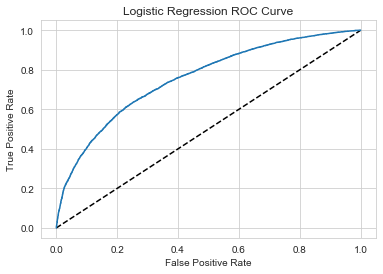

In [54]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)

/Users/sarabouazzaoui/.pyenv/versions/3.7.0/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


It takes 109.129 seconds for Random Forest fitting
Accuracy with Random Foreston the testing set is: 0.778
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8045      1314   9359
Retained              2012      3629   5641
Total                10057      4943  15000
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9359
           1       0.73      0.64      0.69      5641

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.77     15000



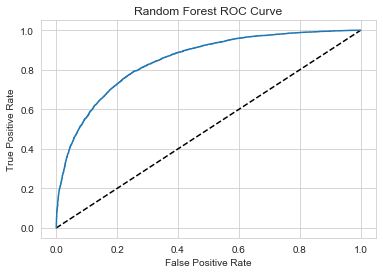

In [55]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_rf)])
rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)

It takes 0.209 seconds for Naive Bayes fitting
Accuracy with Naive Bayeson the testing set is: 0.692
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          6419      2940   9359
Retained              1678      3963   5641
Total                 8097      6903  15000
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      9359
           1       0.57      0.70      0.63      5641

    accuracy                           0.69     15000
   macro avg       0.68      0.69      0.68     15000
weighted avg       0.71      0.69      0.70     15000



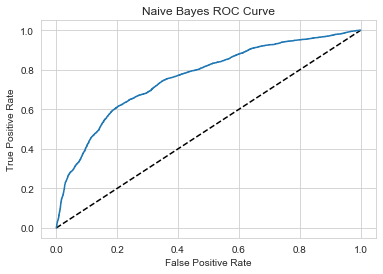

In [56]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_nb)])
nb_cv = train_and_score_model('Naive Bayes', pipeline, param_grid_nb)

In [57]:
from pandas.plotting import table
metrics.astype(float).round(3)
actual_metrics = metrics.astype(float).round(3).loc[['accuracy', 'precision', 'recall', 'AUC']]*100
actual_metrics

Logistic Regression  Random Forest  Naive Bayes
accuracy                  71.6           77.8         69.2
precision                 66.8           73.4         57.4
recall                    48.9           64.3         70.3
AUC                       75.7           84.8         76.1

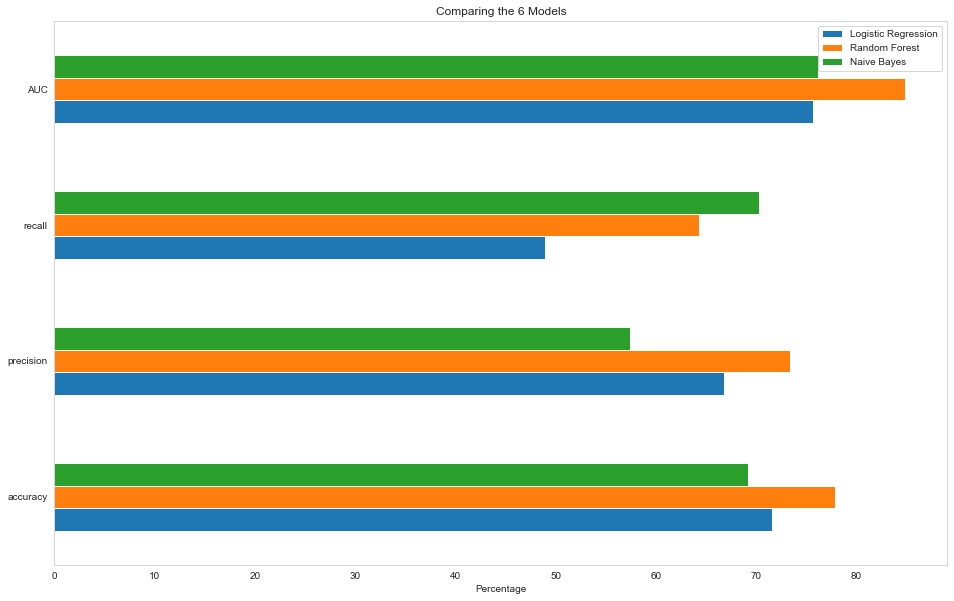

In [58]:
fig, ax = plt.subplots(figsize=(16,10))
actual_metrics.plot(kind='barh', ax=ax)
ax.set_xlabel('Percentage')
ax.set_title('Comparing the 6 Models')
ax.grid();

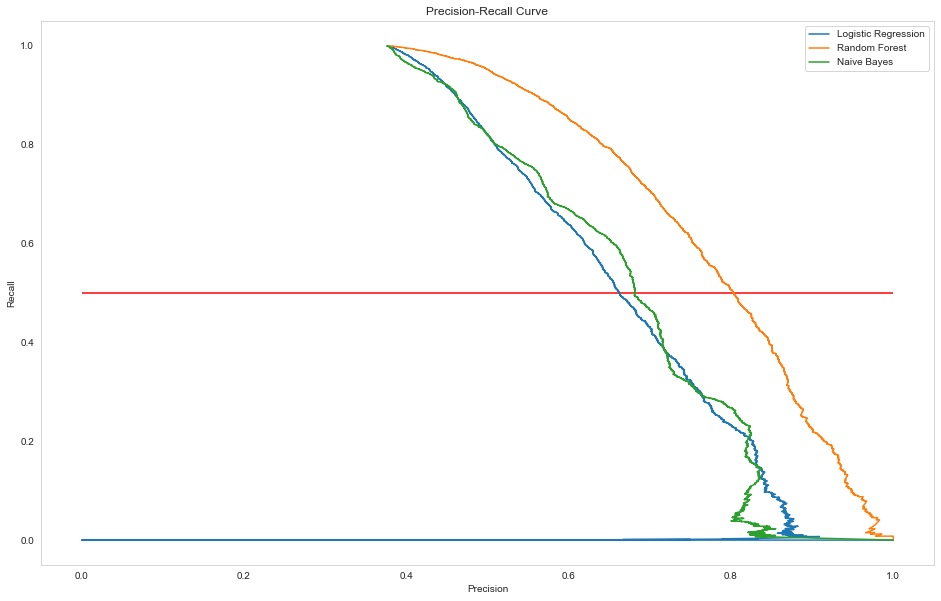

In [60]:

precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true=y_test, probas_pred=lr_cv.predict_proba(X_test)[:,1])
#precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true=y_test, probas_pred=knn_cv.predict_proba(X_test)[:,1])
#precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_true=y_test, probas_pred=svm.predict_proba(X_test)[:,1])
#precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_true=y_test, probas_pred=dt_cv.predict_proba(X_test)[:,1])
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true=y_test, probas_pred=rf_cv.predict_proba(X_test)[:,1])
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true=y_test, probas_pred=nb_cv.predict_proba(X_test)[:,1])

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(precision_lr, recall_lr, label='Logistic Regression')
#ax.plot(precision_knn, recall_knn, label='KNN')
#ax.plot(precision_dt, recall_dt, label='Decision Tree')
ax.plot(precision_rf, recall_rf, label='Random Forest')
ax.plot(precision_nb, recall_nb, label='Naive Bayes')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin=0, xmax=1, color='red')
ax.legend()
ax.grid();

Random Forest produces the best model, with an accuracy of about 78%. This is about 15.5% better than the Dummy Model which just predicts that the user was not retained for every user. So it's a sizable improvement. In addition to having the highest accuracy of any model, we also see that is has the best AUC score of any model, or the best tradeoff between True positive rate and False positive rate (positive rate' is defined as the rate at which we correctly identify 'retained')

Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

In [61]:
rf_cv.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 20,
 'classifier__max_features': 5,
 'classifier__min_samples_leaf': 8,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 50,
 'preprocessor__num__imputer__strategy': 'median'}

In [62]:
rf_model = rf_cv.best_estimator_

In [63]:
rf_model.named_steps['classifier'].feature_importances_

array([0.11438857, 0.15151712, 0.04725017, 0.07340846, 0.07620102,
       0.10691598, 0.0660138 , 0.04709526, 0.11757918, 0.02166871,
       0.09307184, 0.01712414, 0.03794196, 0.00022353, 0.02960028])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null int64
phone                     50000 non-null object
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
was_retained              50000 non-null int64
dtypes: bool(1), float64(6), int64(4), object(2)
memory usage: 4.6+ MB


In [65]:
df.describe()

avg_dist  avg_rating_by_driver  avg_rating_of_driver     avg_surge  \
count  50000.000000          49799.000000          41878.000000  50000.000000   
mean       5.796827              4.778158              4.601559      1.074764   
std        5.707357              0.446652              0.617338      0.222336   
min        0.000000              1.000000              1.000000      1.000000   
25%        2.420000              4.700000              4.300000      1.000000   
50%        3.880000              5.000000              4.900000      1.000000   
75%        6.940000              5.000000              5.000000      1.050000   
max      160.960000              5.000000              5.000000      8.000000   

       last_trip_date  signup_date     surge_pct  trips_in_first_30_days  \
count    50000.000000  50000.00000  50000.000000            50000.000000   
mean       109.334780     16.54468      8.849536                2.278200   
std         61.718985      8.75422     19.958811                3.792684   
min          1.000000      1.00000      0.000000                0.000000   
25%         45.000000      9.00000      0.000000                0.000000   
50%        128.000000     17.00000      0.000000                1.000000   
75%        169.000000     24.00000      8.600000                3.000000   
max        182.000000     31.00000    100.000000              125.000000   

        weekday_pct  was_retained  
count  50000.000000  50000.000000  
mean      60.926084      0.376080  
std       37.081503      0.484405  
min        0.000000      0.000000  
25%       33.300000      0.000000  
50%       66.700000      0.000000  
75%      100.000000      1.000000  
max      100.000000      1.000000

In [66]:
with open('datasets/ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

df['was_retained'] = (df.last_trip_date >= '2014-06-01')*1
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
df['last_trip_date'] = (df['last_trip_date'] - min(df['last_trip_date'])).dt.days + 1 

df.phone.fillna('Other', inplace=True)
df['city'] = df['city'].astype('category')
df['phone'] = df['phone'].astype('category')
df = pd.get_dummies(df)

In [67]:
# Imputation
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean(),inplace=True)
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean(),inplace=True)

In [68]:
X = df.drop(['was_retained', 'last_trip_date'], axis=1)
y = df['was_retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [69]:
classifier_rf = RandomForestClassifier(random_state=0, criterion='gini', max_depth=20, 
                                       max_features=4, min_samples_leaf=7, min_samples_split=5, n_estimators=100)

It takes 3.348 seconds for Random Forest fitting
Accuracy with Random Foreston the testing set is: 0.780
ROC AUC score is: 0.847
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8049      1310   9359
Retained              1996      3645   5641
Total                10045      4955  15000
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9359
           1       0.74      0.65      0.69      5641

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000



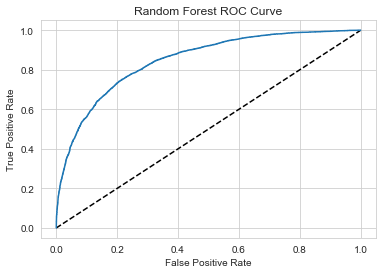

In [70]:
    t0 = time.time()
    classifier_rf.fit(X_train, y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, 'Random Forest'))

    # Predict on Test

    y_pred = classifier_rf.predict(X_test)

    # Scoring
    ##### Accuracy

    print("Accuracy with " + 'Random Forest' + "on the testing set is: %.3f" % classifier_rf.score(X_test, y_test))
    
    y_pred_prob = classifier_rf.predict_proba(X_test)[:,1]
    print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

    print(Conf_Matrix(confusion_matrix(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label='Random Forest')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s ROC Curve' % 'Random Forest')
    plt.show()

In [71]:
pd.DataFrame(classifier_rf.feature_importances_, 
             index = X_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

importance
avg_rating_by_driver      0.164041
surge_pct                 0.122396
weekday_pct               0.118535
city_King's Landing       0.100822
avg_dist                  0.089319
avg_surge                 0.073121
trips_in_first_30_days    0.062947
signup_date               0.060186
ultimate_black_user       0.052362
avg_rating_of_driver      0.041363
phone_Android             0.038457
phone_iPhone              0.033854
city_Astapor              0.024265
city_Winterfell           0.018033
phone_Other               0.000297

We see that the top 3 features in terms of importance are the rider’s average rating over all of their trips, the percent of trips taken with surge multiplier > 1, and the percent of the user's trip occuring during a weekday. 

In [72]:
display(df['avg_rating_by_driver'].corr(df['was_retained']))
display(df['surge_pct'].corr(df['was_retained']))
display(df['weekday_pct'].corr(df['was_retained']))

-0.02674804280607086

0.011796748066780126

0.009692972843291884

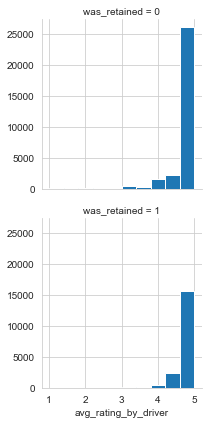

In [73]:
g = sns.FacetGrid(df, row='was_retained')
g = g.map(plt.hist, "avg_rating_by_driver")

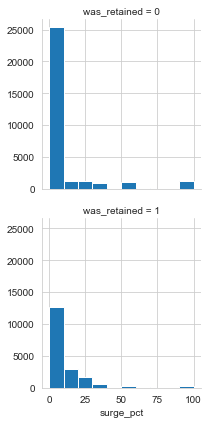

In [74]:
g = sns.FacetGrid(df, row='was_retained')
g = g.map(plt.hist, "surge_pct")

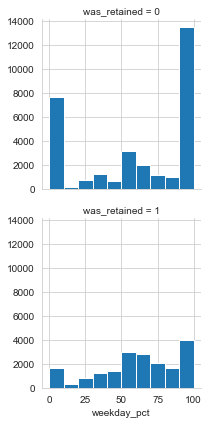

In [75]:
g = sns.FacetGrid(df, row='was_retained')
g = g.map(plt.hist, "weekday_pct")

We see that the non-retained user distribution shows far more users who either only use it on the weekend, or only use it during the week.